# PGT Waste Classification (Plastic, Glass, Tin) v1.0 (Transer Learning)

*Upload waste data sets from Google Drive*

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


***Unzip waste data set to working directory in Colab***

In [2]:
#Import the libraries
import zipfile
import os

zip_ref = zipfile.ZipFile('/content/drive/MyDrive/MyData/wastedata.zip', 'r') #Opens the zip file in read mode
zip_ref.extractall('/content') #Extracts the files into the /tmp folder
zip_ref.close()

***Import MobileNet_v2 (for Transfer Learning)***

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input, decode_predictions
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout #Conv2D,  MaxPool2D 
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint



In [4]:
target_img_shape=(128, 128)  


train_dir = './train_set'  

val_dir = './val_set' 

train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input) 


train_set = train_datagen.flow_from_directory(train_dir,
                                                 target_size=target_img_shape,
                                                 batch_size=32,
                                                 class_mode='sparse')

val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input) 
    
val_set = val_datagen.flow_from_directory(val_dir,
                                            target_size=target_img_shape,
                                            batch_size=32,
                                            class_mode='sparse')

Found 3277 images belonging to 3 classes.
Found 823 images belonging to 3 classes.


{'AluCan': 0, 'Glass': 1, 'Plastic': 2}
(32, 128, 128, 3)
(32,)
0.0 1.0
class: 2.0


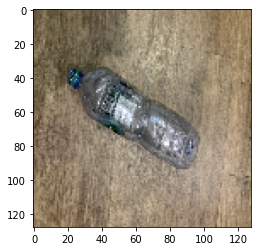

In [5]:
print(train_set.class_indices)


for image_batch, labels_batch in train_set:
    print(image_batch.shape)
    print(labels_batch.shape)
    
    img = image_batch[0] - image_batch[0].min()
    img /= 2.0
   
    print(img.min(), img.max())
    plt.imshow(img)

    print('class:', labels_batch[0])    
    break

In [6]:
ids, counts = np.unique(train_set.classes, return_counts=True)

print(ids)
print(counts)

[0 1 2]
[ 894 1110 1273]


In [7]:
labels = (train_set.class_indices)
labels = dict((v,k) for k,v in labels.items())
labels   

for i in ids:
    print('{:>8} = {}' . format(labels[i], counts[i]))


  AluCan = 894
   Glass = 1110
 Plastic = 1273


In [8]:
label_names = [k for k in train_set.class_indices]
label_names

['AluCan', 'Glass', 'Plastic']

In [9]:
import pandas as pd

df_train_labels = pd.DataFrame({'Label':label_names, 'Count':counts})
df_train_labels.set_index('Label', inplace=True)
df_train_labels

Count
Label         
AluCan     894
Glass     1110
Plastic   1273

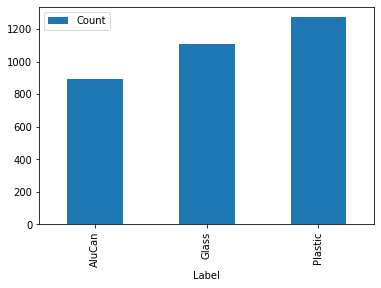

In [10]:
df_train_labels.plot.bar()
plt.show()

In [11]:
ids, counts = np.unique(val_set.classes, return_counts=True)

print(ids)
print(counts)

[0 1 2]
[227 277 319]


In [12]:
_, train_count = np.unique(train_set.classes, return_counts=True)
_, val_count = np.unique(val_set.classes, return_counts=True)

print('Ratio Validation/Training set:', val_count/train_count * 100)

Ratio Validation/Training set: [25.39149888 24.95495495 25.05891595]


In [13]:
in_shape = (target_img_shape[0], target_img_shape[1], 3)  


base_model = MobileNetV2(include_top=False, weights='imagenet',
                   input_shape=in_shape)  

model = Sequential()

model.add(base_model)
model.add(Flatten())
model.add(Dense(256, activation='relu'))  
model.add(Dropout(0.4))
model.add(Dense(128, activation='relu'))  
model.add(Dropout(0.4))
model.add(Dense(3, activation='softmax'))  

model.summary()

9420800/9406464 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_128 (Funct  (None, 4, 4, 1280)       2257984   
 ional)                                                          
                                                                 
 flatten (Flatten)           (None, 20480)             0         
                                                                 
 dense (Dense)               (None, 256)               5243136   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0   

In [14]:
base_model.trainable = False 

In [15]:
print("Trainable..\n---")
for variable in model.trainable_variables:
    print(variable.name)  

Trainable..
---
dense/kernel:0
dense/bias:0
dense_1/kernel:0
dense_1/bias:0
dense_2/kernel:0
dense_2/bias:0


In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_128 (Funct  (None, 4, 4, 1280)       2257984   
 ional)                                                          
                                                                 
 flatten (Flatten)           (None, 20480)             0         
                                                                 
 dense (Dense)               (None, 256)               5243136   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                        

In [17]:
import time

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', 
             metrics=['accuracy'])

es = EarlyStopping(monitor='val_loss', verbose=1, patience=5) # 
mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', verbose=1, save_best_only=True)

start = time.time()
history = model.fit(train_set, 
                     validation_data=val_set, 
                    epochs=20, verbose=1, callbacks=[es, mc])

end = time.time()
print("Time Taken: {:.2f} minutes".format((end - start)/60))

Epoch 1/20
103/103 [==============================] - ETA: 0s - loss: 1.5329 - accuracy: 0.6988
Epoch 1: val_accuracy improved from -inf to 0.87120, saving model to best_model.h5
103/103 [==============================] - 61s 560ms/step - loss: 1.5329 - accuracy: 0.6988 - val_loss: 0.3387 - val_accuracy: 0.8712
Epoch 2/20
103/103 [==============================] - ETA: 0s - loss: 0.4363 - accuracy: 0.8468
Epoch 2: val_accuracy improved from 0.87120 to 0.92588, saving model to best_model.h5
103/103 [==============================] - 58s 560ms/step - loss: 0.4363 - accuracy: 0.8468 - val_loss: 0.2147 - val_accuracy: 0.9259
Epoch 3/20
103/103 [==============================] - ETA: 0s - loss: 0.3582 - accuracy: 0.8792
Epoch 3: val_accuracy did not improve from 0.92588
103/103 [==============================] - 59s 575ms/step - loss: 0.3582 - accuracy: 0.8792 - val_loss: 0.2691 - val_accuracy: 0.9004
Epoch 4/20
103/103 [==============================] - ETA: 0s - loss: 0.2659 - accuracy: 0

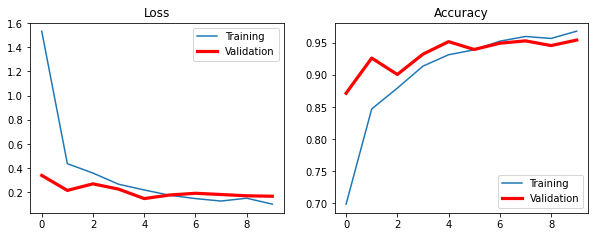

In [18]:
plt.figure(figsize=(10, 3.5))
plt.subplot(1, 2, 1)

plt.title('Loss')
plt.plot(history.history['loss'], label='Training')
plt.plot(history.history['val_loss'],'r', lw=3.2, label='Validation')
plt.legend()

plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='Training')
plt.plot(history.history['val_accuracy'], 'r', lw=3.2, label='Validation')

plt.legend()
plt.show()

In [19]:
print(len(val_set))
acc = model.evaluate(val_set, verbose=1)
print('score = {:.3f}' .format(acc[1]))

26
26/26 [==============================] - 11s 426ms/step - loss: 0.1664 - accuracy: 0.9538
score = 0.954


*Predict*

In [20]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

def predict(img_fname):
    img = load_img(img_fname, target_size=target_img_shape) 
    plt.imshow(img)
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    
    pred = model.predict(img)  
    pred_cls = labels[np.argmax(pred, -1)[0]]   
    print('Prediction:', pred_cls, pred[0].round(3))
    return(pred_cls, pred) 

In [21]:
labels = (train_set.class_indices)
labels = dict((v,k) for k,v in labels.items())
labels 

{0: 'AluCan', 1: 'Glass', 2: 'Plastic'}

Prediction: AluCan [0.995 0.002 0.003]


'AluCan'

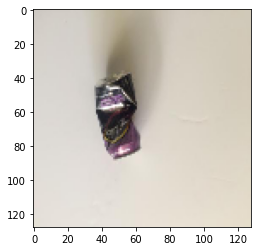

In [22]:
_,pred_result = predict('./val_set/AluCan/AluCan_9002.jpg')
labels[np.argmax(pred_result, -1)[0]]

Prediction: Glass [0.001 0.996 0.003]


'Glass'

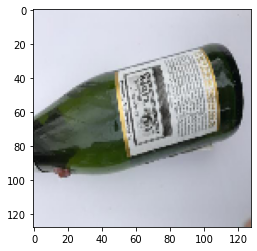

In [23]:
_,pred_result = predict('./val_set/Glass/Glass_9002.jpg')
labels[np.argmax(pred_result, -1)[0]]

Prediction: Plastic [0.001 0.144 0.854]


'Plastic'

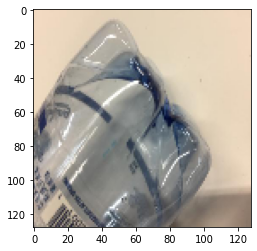

In [27]:
_,pred_result = predict('./test_set/0056.jpg')
labels[np.argmax(pred_result, -1)[0]]

Prediction: Plastic [0. 0. 1.]
Plastic


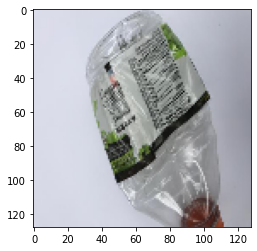

Prediction: Glass [0.    0.998 0.002]
Glass


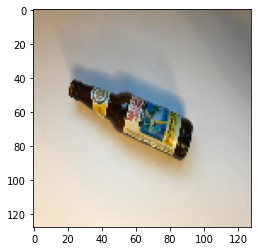

Prediction: Glass [0. 1. 0.]
Glass


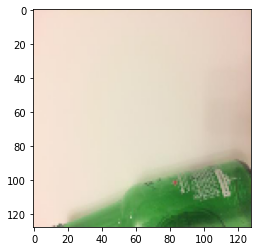

Prediction: Plastic [0. 0. 1.]
Plastic


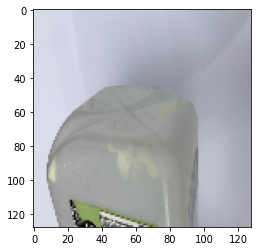

Prediction: Plastic [0. 0. 1.]
Plastic


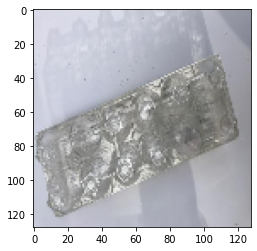

Prediction: Glass [0.    0.995 0.005]
Glass


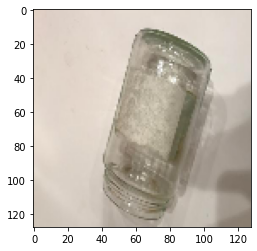

Prediction: Plastic [0. 0. 1.]
Plastic


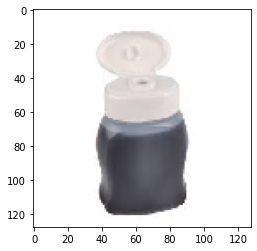

Prediction: Glass [0. 1. 0.]
Glass


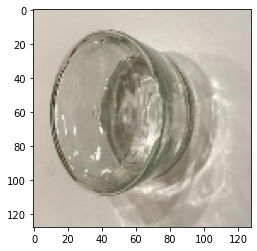

Prediction: Plastic [0. 0. 1.]
Plastic


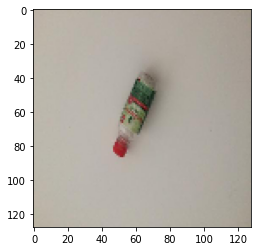

Prediction: Glass [0.001 0.999 0.   ]
Glass


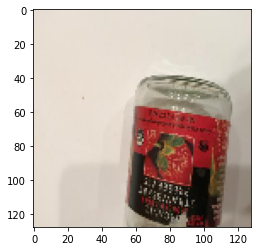

Prediction: Plastic [0.283 0.344 0.373]
Plastic


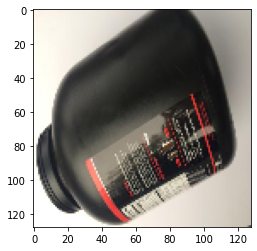

Prediction: Glass [0. 1. 0.]
Glass


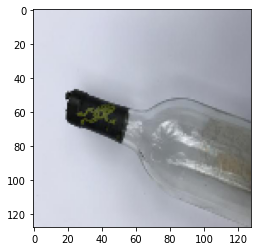

Prediction: AluCan [1. 0. 0.]
AluCan


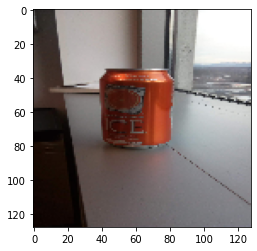

Prediction: Glass [0. 1. 0.]
Glass


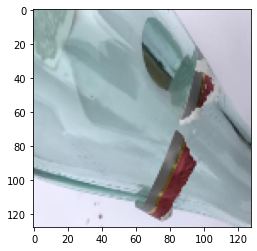

Prediction: Glass [0. 1. 0.]
Glass


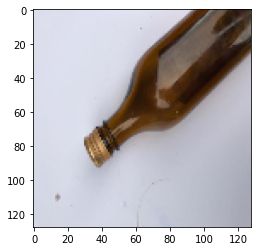

Prediction: Glass [0.    0.998 0.002]
Glass


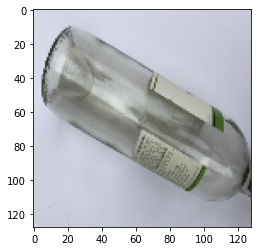

Prediction: Glass [0. 1. 0.]
Glass


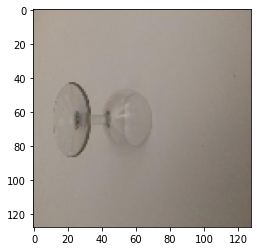

Prediction: Glass [0.028 0.971 0.001]
Glass


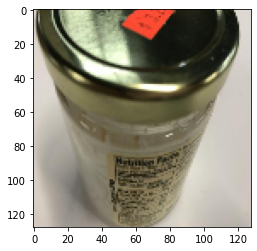

Prediction: Glass [0. 1. 0.]
Glass


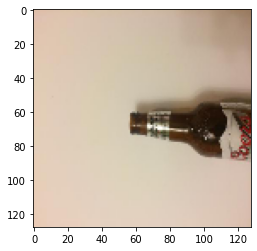

Prediction: Glass [0.025 0.967 0.008]
Glass


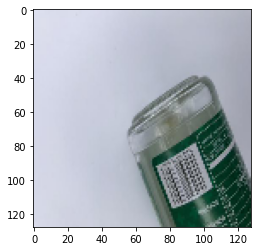

Prediction: Plastic [0. 0. 1.]
Plastic


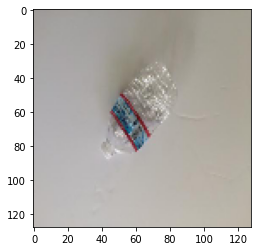

Prediction: Plastic [0.005 0.017 0.979]
Plastic


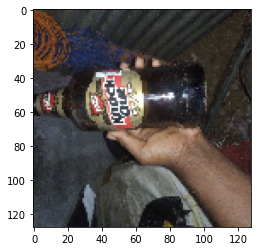

Prediction: Glass [0.007 0.991 0.002]
Glass


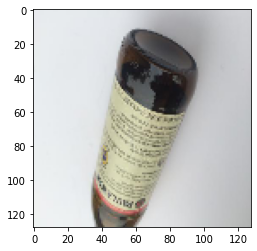

Prediction: Plastic [0. 0. 1.]
Plastic


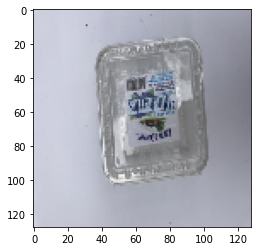

Prediction: Glass [0.    0.98  0.019]
Glass


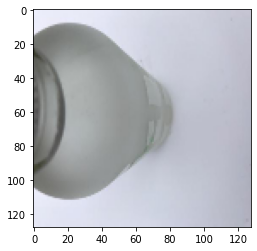

Prediction: Plastic [0. 0. 1.]
Plastic


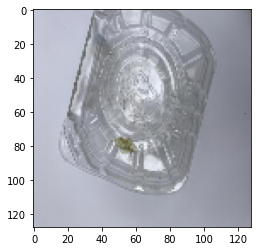

Prediction: Plastic [0.007 0.063 0.93 ]
Plastic


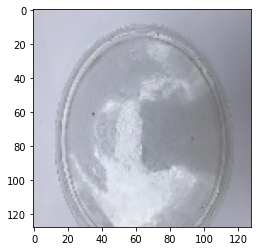

Prediction: Glass [0. 1. 0.]
Glass


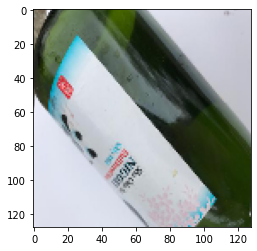

Prediction: Glass [0.001 0.964 0.035]
Glass


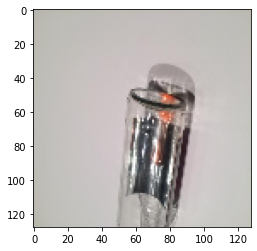

Prediction: Glass [0. 1. 0.]
Glass


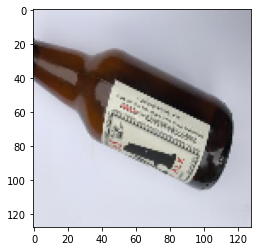

Prediction: AluCan [0.498 0.057 0.446]
AluCan


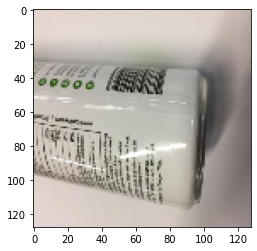

Prediction: Glass [0.    0.996 0.004]
Glass


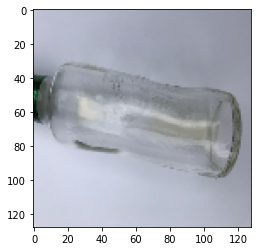

Prediction: Glass [0.   0.97 0.03]
Glass


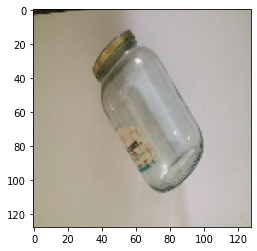

Prediction: AluCan [1. 0. 0.]
AluCan


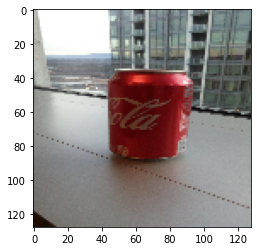

Prediction: Glass [0.002 0.989 0.009]
Glass


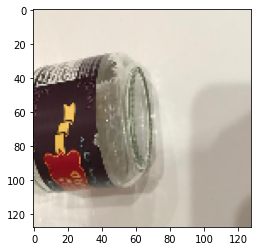

Prediction: Glass [0.    0.992 0.008]
Glass


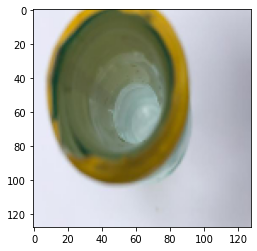

Prediction: Glass [0. 1. 0.]
Glass


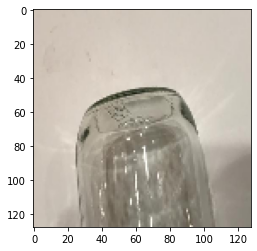

Prediction: Glass [0.007 0.992 0.001]
Glass


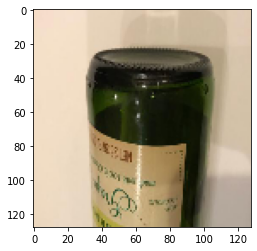

Prediction: Plastic [0.    0.    0.999]
Plastic


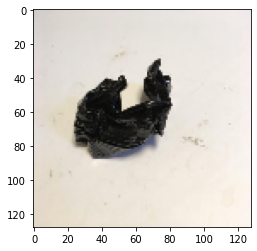

Prediction: Plastic [0. 0. 1.]
Plastic


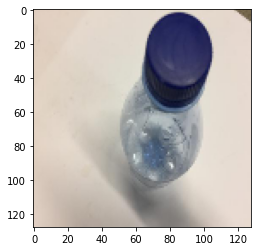

Prediction: Glass [0.043 0.916 0.04 ]
Glass


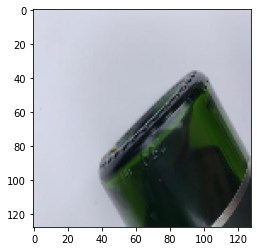

Prediction: Plastic [0. 0. 1.]
Plastic


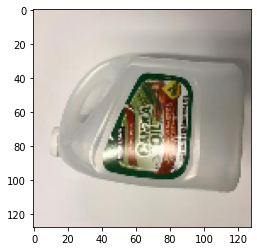

Prediction: Glass [0. 1. 0.]
Glass


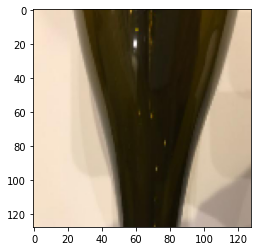

Prediction: Plastic [0. 0. 1.]
Plastic


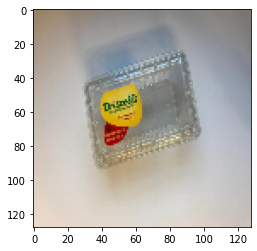

Prediction: Glass [0. 1. 0.]
Glass


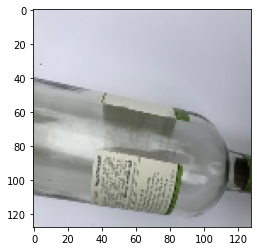

Prediction: Glass [0. 1. 0.]
Glass


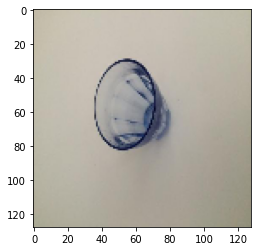

Prediction: Plastic [0.302 0.058 0.64 ]
Plastic


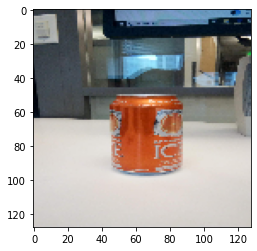

Prediction: Glass [0.001 0.97  0.029]
Glass


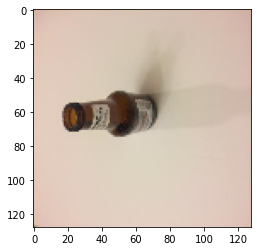

Prediction: Plastic [0. 0. 1.]
Plastic


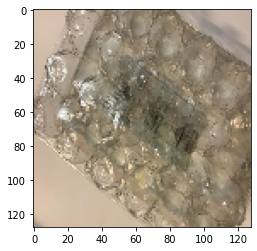

Prediction: Glass [0. 1. 0.]
Glass


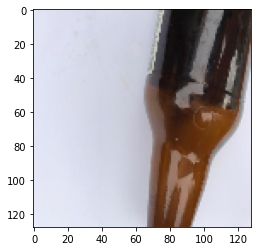

Prediction: Plastic [0. 0. 1.]
Plastic


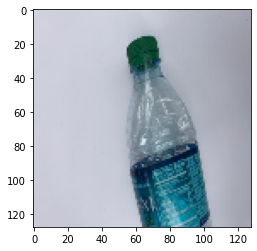

Prediction: Glass [0. 1. 0.]
Glass


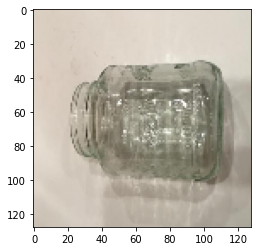

Prediction: Plastic [0. 0. 1.]
Plastic


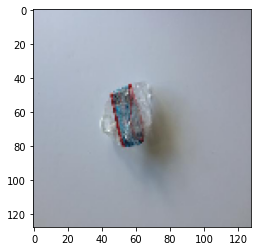

Prediction: Plastic [0. 0. 1.]
Plastic


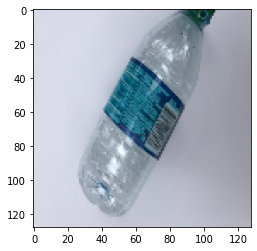

Prediction: Plastic [0. 0. 1.]
Plastic


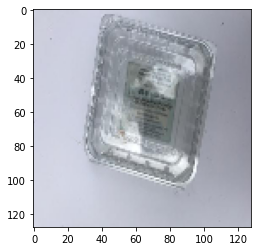

Prediction: Glass [0. 1. 0.]
Glass


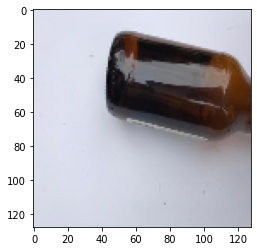

Prediction: Plastic [0. 0. 1.]
Plastic


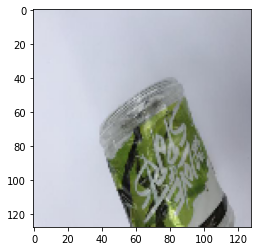

Prediction: Plastic [0.003 0.1   0.897]
Plastic


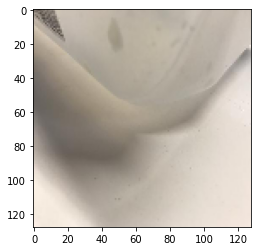

Prediction: Plastic [0. 0. 1.]
Plastic


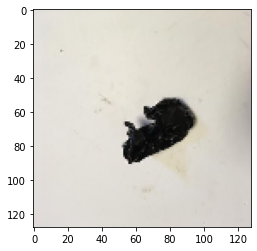

Prediction: Glass [0.002 0.991 0.007]
Glass


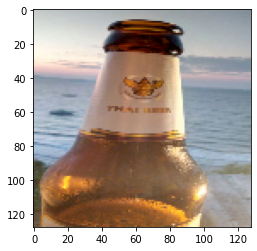

Prediction: Plastic [0.039 0.209 0.752]
Plastic


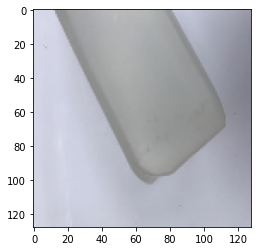

Prediction: Glass [0. 1. 0.]
Glass


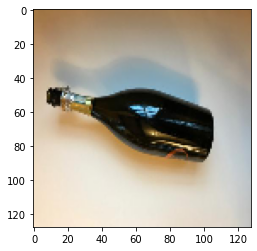

Prediction: Plastic [0.041 0.127 0.832]
Plastic


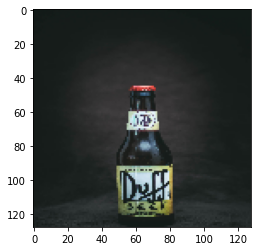

Prediction: Glass [0. 1. 0.]
Glass


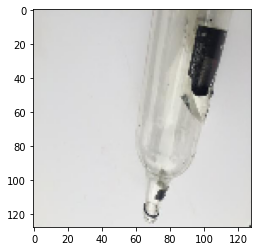

Prediction: Plastic [0. 0. 1.]
Plastic


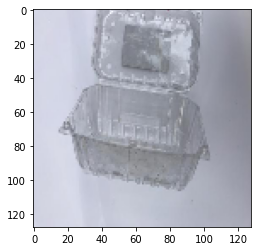

Prediction: Plastic [0. 0. 1.]
Plastic


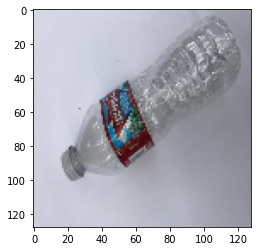

Prediction: Glass [0. 1. 0.]
Glass


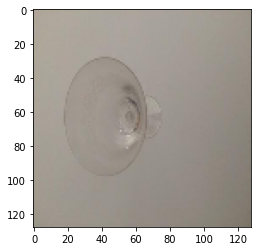

Prediction: AluCan [1. 0. 0.]
AluCan


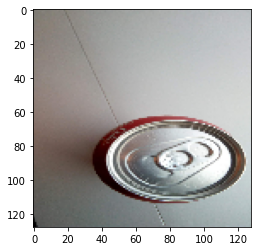

Prediction: Plastic [0.015 0.022 0.964]
Plastic


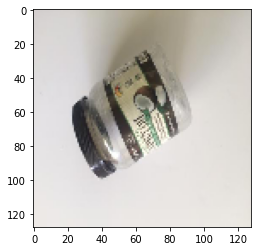

Prediction: Glass [0. 1. 0.]
Glass


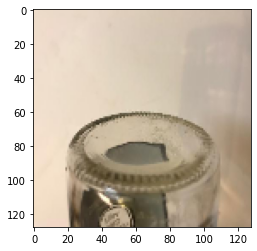

Prediction: Glass [0.046 0.81  0.144]
Glass


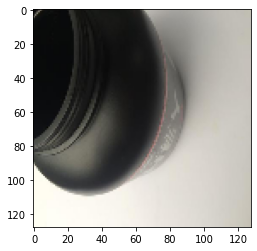

Prediction: Plastic [0.001 0.017 0.982]
Plastic


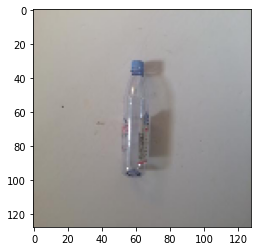

Prediction: Plastic [0. 0. 1.]
Plastic


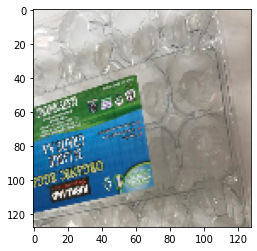

Prediction: Glass [0.008 0.534 0.458]
Glass


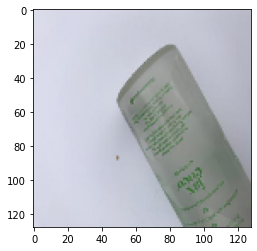

Prediction: Glass [0.147 0.558 0.295]
Glass


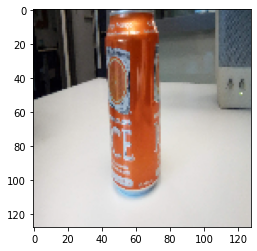

Prediction: Glass [0. 1. 0.]
Glass


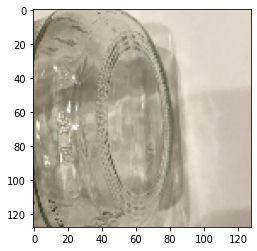

Prediction: Plastic [0. 0. 1.]
Plastic


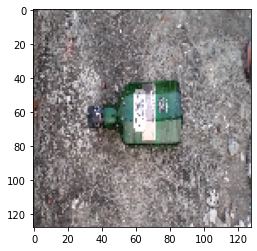

Prediction: Plastic [0.    0.    0.999]
Plastic


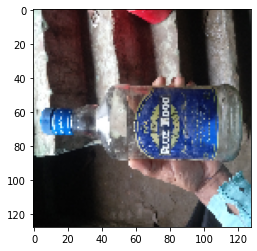

Prediction: Plastic [0.    0.006 0.994]
Plastic


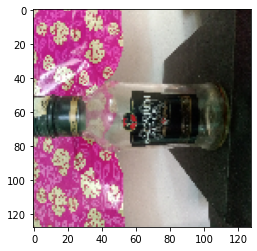

Prediction: Plastic [0.001 0.144 0.854]
Plastic


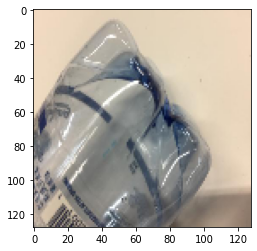

Prediction: Plastic [0. 0. 1.]
Plastic


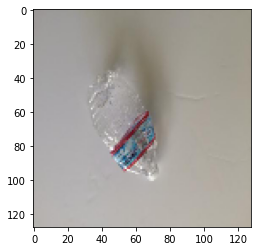

Prediction: Plastic [0. 0. 1.]
Plastic


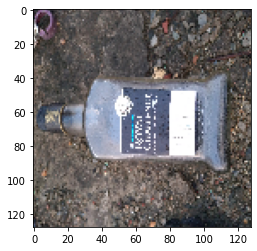

Prediction: Plastic [0. 0. 1.]
Plastic


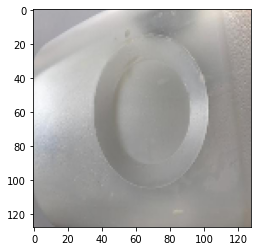

Prediction: Glass [0. 1. 0.]
Glass


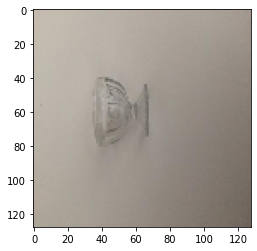

Prediction: Plastic [0.095 0.246 0.659]
Plastic


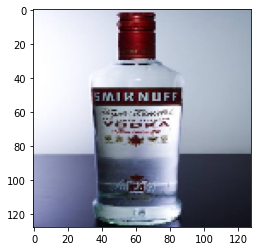

Prediction: Plastic [0.008 0.007 0.985]
Plastic


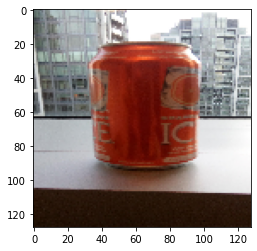

Prediction: Glass [0. 1. 0.]
Glass


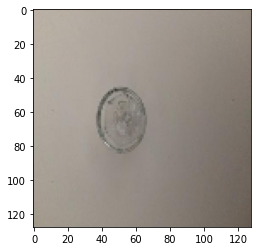

Prediction: Glass [0.066 0.669 0.265]
Glass


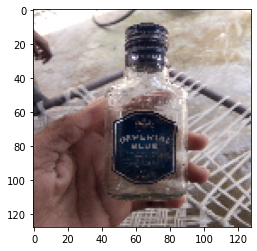

Prediction: Glass [0. 1. 0.]
Glass


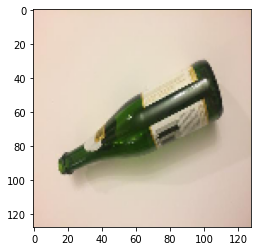

Prediction: Plastic [0. 0. 1.]
Plastic


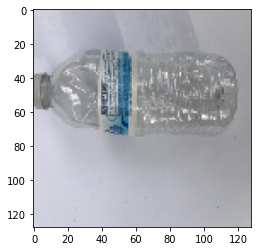

Prediction: Plastic [0. 0. 1.]
Plastic


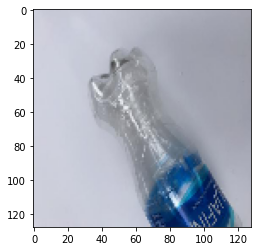

Prediction: Plastic [0.009 0.014 0.976]
Plastic


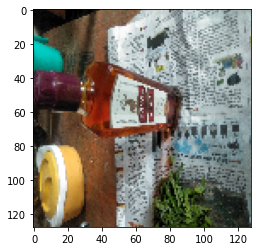

Prediction: Glass [0. 1. 0.]
Glass


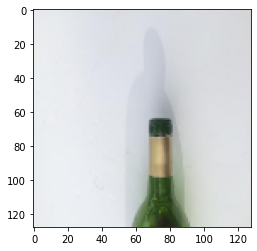

Prediction: Glass [0.    0.999 0.001]
Glass


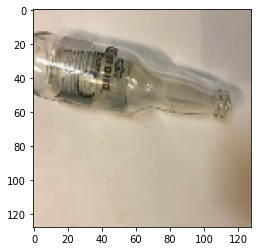

Prediction: Plastic [0. 0. 1.]
Plastic


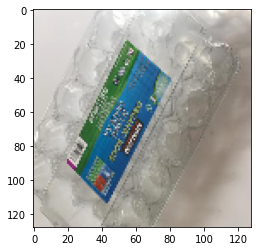

Prediction: Glass [0.003 0.971 0.025]
Glass


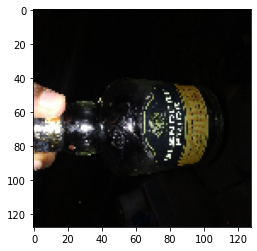

Prediction: AluCan [1. 0. 0.]
AluCan


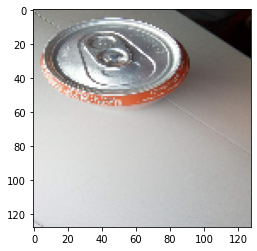

Prediction: Glass [0. 1. 0.]
Glass


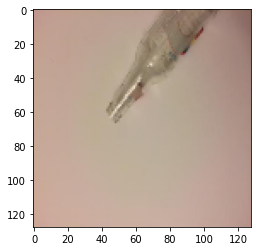

Prediction: Plastic [0. 0. 1.]
Plastic


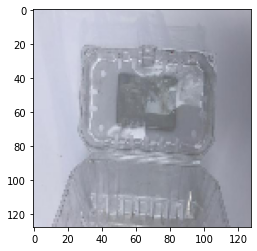

Prediction: Plastic [0.483 0.004 0.512]
Plastic


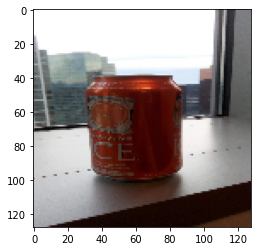

Prediction: Plastic [0.014 0.035 0.951]
Plastic


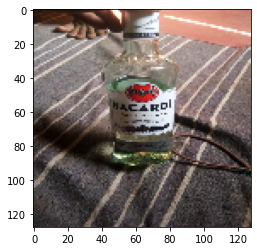

Prediction: AluCan [1. 0. 0.]
AluCan


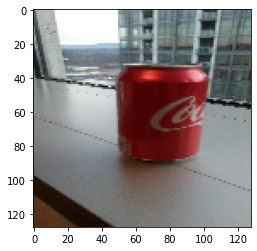

Prediction: AluCan [0.998 0.001 0.001]
AluCan


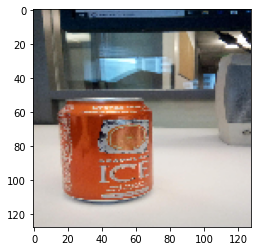

Prediction: Plastic [0. 0. 1.]
Plastic


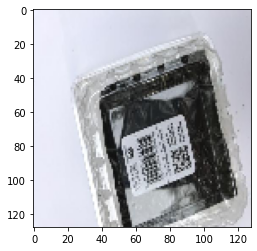

Prediction: AluCan [0.998 0.001 0.001]
AluCan


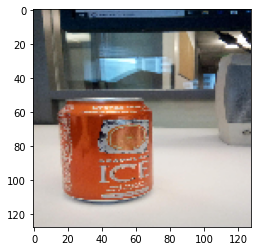

Prediction: Plastic [0. 0. 1.]
Plastic


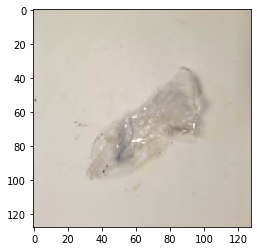

Prediction: Glass [0.031 0.967 0.001]
Glass


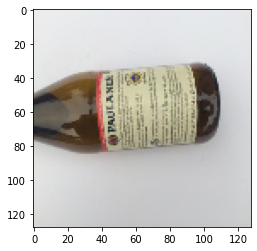

Prediction: Plastic [0.001 0.003 0.996]
Plastic


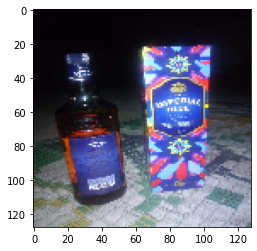

Prediction: Glass [0.    0.999 0.001]
Glass


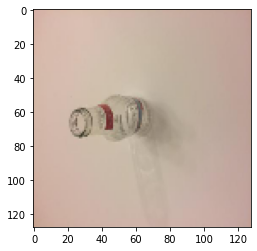

Prediction: Glass [0. 1. 0.]
Glass


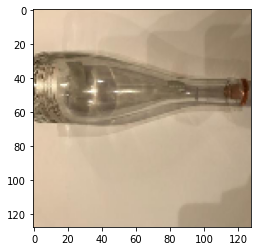

Prediction: AluCan [1. 0. 0.]
AluCan


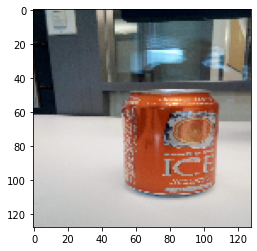

Prediction: Plastic [0.028 0.051 0.921]
Plastic


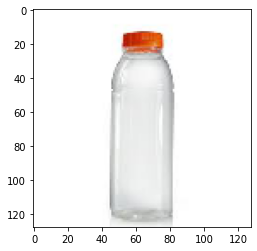

Prediction: Glass [0.002 0.96  0.039]
Glass


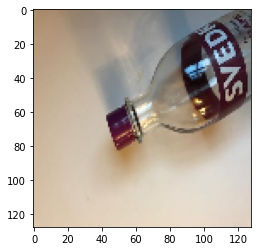

Prediction: AluCan [1. 0. 0.]
AluCan


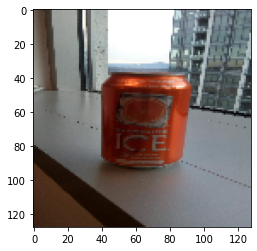

Prediction: Plastic [0.004 0.018 0.978]
Plastic


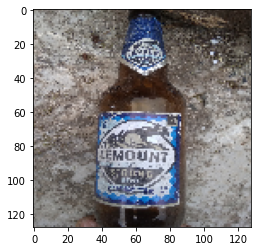

Prediction: Plastic [0. 0. 1.]
Plastic


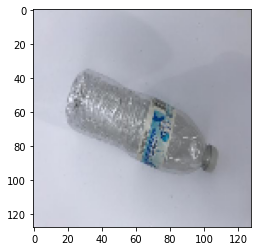

Prediction: Plastic [0. 0. 1.]
Plastic


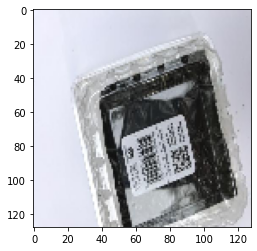

Prediction: Glass [0. 1. 0.]
Glass


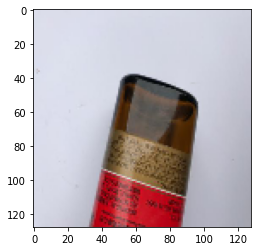

Prediction: AluCan [1. 0. 0.]
AluCan


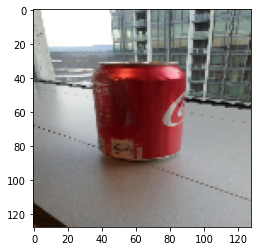

Prediction: Glass [0.248 0.727 0.025]
Glass


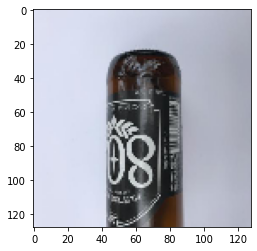

Prediction: Plastic [0.001 0.016 0.983]
Plastic


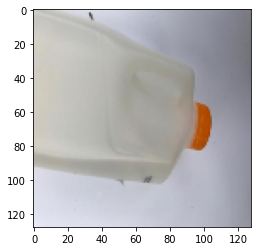

Prediction: Plastic [0.001 0.01  0.989]
Plastic


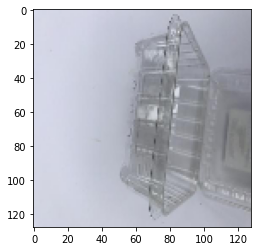

In [28]:
import glob

mytestlist = [f for f in glob.glob('./test_set/*')]
for testimg in mytestlist:
  index = mytestlist.index(testimg)
  mypredlist,pred_result = predict(mytestlist[index])
  print(labels[np.argmax(pred_result, -1)[0]]) 
  plt.show()

***Save Model in .h5 for Use***

In [29]:
model.save('./pgt_model.h5')

***Save Model in folder for Use***

In [30]:
model.save('./mypgtmodel')

INFO:tensorflow:Assets written to: ./mypgtmodel/assets


INFO:tensorflow:Assets written to: ./mypgtmodel/assets


***Save class config to decode prediction result to class name*** *(Plastic, Glass, Alucan)*

In [37]:
import pickle
file_name = 'classname.pkl'
open_file = open(file_name, "wb")
pickle.dump(labels, open_file)
open_file.close()

***Load h5 for Use***

In [38]:
from tensorflow.keras.models import load_model  # lib load model
my_model = load_model('./pgt_model.h5') # load model h5

In [39]:
my_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_128 (Funct  (None, 4, 4, 1280)       2257984   
 ional)                                                          
                                                                 
 flatten (Flatten)           (None, 20480)             0         
                                                                 
 dense (Dense)               (None, 256)               5243136   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                        

In [40]:
my_model.get_config()

{'layers': [{'class_name': 'InputLayer',
   'config': {'batch_input_shape': (None, 128, 128, 3),
    'dtype': 'float32',
    'name': 'mobilenetv2_1.00_128_input',
    'ragged': False,
    'sparse': False}},
  {'class_name': 'Functional',
   'config': {'input_layers': [['input_1', 0, 0]],
    'layers': [{'class_name': 'InputLayer',
      'config': {'batch_input_shape': (None, 128, 128, 3),
       'dtype': 'float32',
       'name': 'input_1',
       'ragged': False,
       'sparse': False},
      'inbound_nodes': [],
      'name': 'input_1'},
     {'class_name': 'Conv2D',
      'config': {'activation': 'linear',
       'activity_regularizer': None,
       'bias_constraint': None,
       'bias_initializer': {'class_name': 'Zeros', 'config': {}},
       'bias_regularizer': None,
       'data_format': 'channels_last',
       'dilation_rate': (1, 1),
       'dtype': 'float32',
       'filters': 32,
       'groups': 1,
       'kernel_constraint': None,
       'kernel_initializer': {'class_nam

In [41]:
import pickle
file_name = "classname.pkl"
open_file = open(file_name, "rb")
class_names = pickle.load(open_file)
open_file.close()
class_names

{0: 'AluCan', 1: 'Glass', 2: 'Plastic'}

[[2.0271209e-05 9.9995017e-01 2.9556069e-05]]


'Glass'

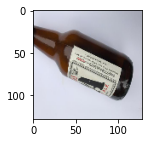

In [75]:
from keras.models import load_model
from keras.preprocessing import image
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input, decode_predictions
import numpy as np
import matplotlib.pyplot as plt

# insert code to take a picture snapshot of image from camara device 
# and save the image file and input the image file 
input_image = './test_set/0074.jpg'
img = image.load_img(input_image, target_size=(128, 128))
plt.figure(figsize=(2, 2))
plt.imshow(img)

pred_image = image.img_to_array(img)
pred_image = np.expand_dims(pred_image, axis=0)
pred_image = preprocess_input(pred_image)

my_model = load_model('./pgt_model.h5') # load model h5
pred_result = my_model.predict(pred_image)
print(pred_result)
class_names[np.argmax(pred_result, -1)[0]]

***Convert .h5 to TensorFlow Lite (Normal)***

In [ ]:
from tensorflow.keras.models import load_model
model = load_model('./pgt_model.h5') # 

In [ ]:
model.summary()
model.get_config()['layers'][0]

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_128 (Funct  (None, 4, 4, 1280)       2257984   
 ional)                                                          
                                                                 
 flatten_1 (Flatten)         (None, 20480)             0         
                                                                 
 dense_3 (Dense)             (None, 256)               5243136   
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_4 (Dense)             (None, 128)               32896     
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                      

{'class_name': 'InputLayer',
 'config': {'batch_input_shape': (None, 128, 128, 3),
  'dtype': 'float32',
  'name': 'mobilenetv2_1.00_128_input',
  'ragged': False,
  'sparse': False}}

In [60]:
import tensorflow as tf
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_pgt_model = converter.convert()

f = open('pgt_model.tflite', "wb")
f.write(tflite_pgt_model)
f.close()

regular_model_size = len(tflite_pgt_model) / 1024
print('Regular model size = %d KBs.' % regular_model_size)

INFO:tensorflow:Assets written to: /tmp/tmp0o8hegrc/assets


INFO:tensorflow:Assets written to: /tmp/tmp0o8hegrc/assets


Regular model size = 29272 KBs.


***Convert .h5 to TensorFlow Lite (Optimized)***

In [61]:
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_optimized_model = converter.convert()

optimized_model_size = len(tflite_optimized_model) / 1024
print('Optimized model size = %d KBs,' % optimized_model_size)
print('which is about %d%% of the regular model size.'\
      % (optimized_model_size * 100 / regular_model_size))

f = open('opt_pgt_model.tflite', "wb")
f.write(tflite_optimized_model)
f.close()

INFO:tensorflow:Assets written to: /tmp/tmpbx7uh6_z/assets


INFO:tensorflow:Assets written to: /tmp/tmpbx7uh6_z/assets


Optimized model size = 7741 KBs,
which is about 26% of the regular model size.


***Use TensorFlow Lite to Predict***

input shape: [  1 128 128   3]
Total prediction time:  0.008409738540649414
Glass


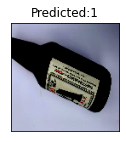

In [74]:
import tensorflow as tf
from time import time

tflite_path = 'pgt_model.tflite' 


interpreter = tf.lite.Interpreter(model_path=tflite_path)
interpreter.allocate_tensors()

input = interpreter.get_input_details()
input_shape = input[0]['shape']
print('input shape:', input_shape)

input_tensor_index = input[0]["index"]
output = interpreter.tensor(interpreter.get_output_details()[0]["index"])

interpreter.set_tensor(input_tensor_index, pred_image) # 

time_start = time()
interpreter.invoke()

time_end = time()
total_tflite_time = time_end - time_start
print("Total prediction time: ", total_tflite_time)

digit = np.argmax(output()[0])
#print(digit)
print(class_names[digit])

plt.figure(figsize=(2, 2))
plt.imshow(pred_image[0], cmap=plt.cm.gray_r)
plt.title('Predicted:{}'. format(digit))
plt.xticks([]) ; plt.yticks([])
plt.show()